In [31]:
# Imports and setup
import sys
from pathlib import Path
import warnings
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ensure plots look decent
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Project paths
project_root = Path.cwd().parent
data_dir = project_root / 'data' / 'raw' / 'fx'
fig_dir = project_root / 'results' / 'figures'
csv_dir = project_root / 'results' / 'csv'
fig_dir.mkdir(parents=True, exist_ok=True)
csv_dir.mkdir(parents=True, exist_ok=True)

# Import loader
sys.path.insert(0, str(project_root))
from src.fx_data_loader import FXDataLoader, FXDataMetadata, FXDataIntegrityError

print('✅ Environment ready')
print(f'Project root: {project_root}')

✅ Environment ready
Project root: /home/ghost/Quant _validation


In [14]:
# Analysis parameters
# Adjust threshold to ensure enough event samples
# 0.2% is a reasonable starting point for hourly GBPUSD
event_threshold = 0.002  # 0.2%

# Horizons to analyze (hours)
fwd_horizons = [1, 4, 24]
print(f"Parameters: event_threshold={event_threshold*100:.2f}% | horizons={fwd_horizons}")


Parameters: event_threshold=0.20% | horizons=[1, 4, 24]


In [34]:
# Load data (prefer processed hourly + metadata)
from pathlib import Path
import json
from src.fx_data_loader import FXDataLoader, FXDataMetadata

processed_csv = Path("data/processed/fx/GBPUSD_hourly.csv")
processed_meta = Path("data/processed/fx/GBPUSD_hourly_metadata.json")
raw_csv = Path("data/raw/fx/GBPUSD.csv")

if processed_csv.exists():
    meta_dict = {}
    if processed_meta.exists():
        try:
            meta_dict = json.loads(processed_meta.read_text())
        except Exception as e:
            print(f"Warning: failed to read metadata: {e}")
    metadata = FXDataMetadata(**{
        "symbol": meta_dict.get("symbol", "GBPUSD"),
        "price_type": meta_dict.get("price_type", "mid"),
        "volume_type": meta_dict.get("volume_type", "none"),
        "timezone": meta_dict.get("timezone", "UTC"),
        "source": meta_dict.get("source", "processed_hourly")
    })
    loader = FXDataLoader(symbol=metadata.symbol, metadata=metadata)
    df = loader.load_csv(str(processed_csv), verify=True)
    print("Loaded processed hourly dataset.")
elif raw_csv.exists():
    metadata = FXDataMetadata(symbol="GBPUSD", price_type="mid", volume_type="none", timezone="UTC", source="raw_hourly")
    loader = FXDataLoader(symbol="GBPUSD", metadata=metadata)
    df = loader.load_csv(str(raw_csv), verify=True)
    print("Loaded raw hourly dataset.")
else:
    raise FileNotFoundError("No GBPUSD CSV found in expected locations.")

# Save integrity report to JSON for downstream audit
results_csv_dir = Path("results/csv")
results_csv_dir.mkdir(parents=True, exist_ok=True)
try:
    integrity_path = results_csv_dir / "gbpusd_integrity_report.json"
    with integrity_path.open("w") as f:
        json.dump(loader.integrity_report, f, indent=2, default=str)
    print(f"Integrity report saved: {integrity_path}")
except Exception as e:
    print(f"Warning: failed to persist integrity report: {e}")

# Session labeling if needed
if "session" not in df.columns:
    df = loader.label_sessions(df)

print(df.head())

FileNotFoundError: No GBPUSD CSV found in expected locations.

In [21]:
# 2. Compute hourly returns and drop NaNs
returns = df['close'].pct_change().dropna()
returns.name = 'ret'
print(f'Total returns: {len(returns)}')
print(returns.head())

Total returns: 17269
timestamp
2023-03-28 00:00:00+00:00    0.001145
2023-03-28 01:00:00+00:00    0.000135
2023-03-28 02:00:00+00:00    0.000185
2023-03-28 03:00:00+00:00    0.000320
2023-03-28 04:00:00+00:00   -0.000234
Name: ret, dtype: float64


## 3. Fat Tails Analysis
- Histogram with Normal and Student-t overlays
- Q-Q plot for normality
- Kurtosis, 3-sigma events, and Jarque-Bera test
- Save figure as `01_fat_tails.png`

Saved: /home/ghost/Quant _validation/results/figures/01_fat_tails.png
--- Fat Tails Diagnostics ---
Kurtosis (Fisher): 10.136
3-sigma events: 274
Jarque-Bera: stat=74007.306, p=0


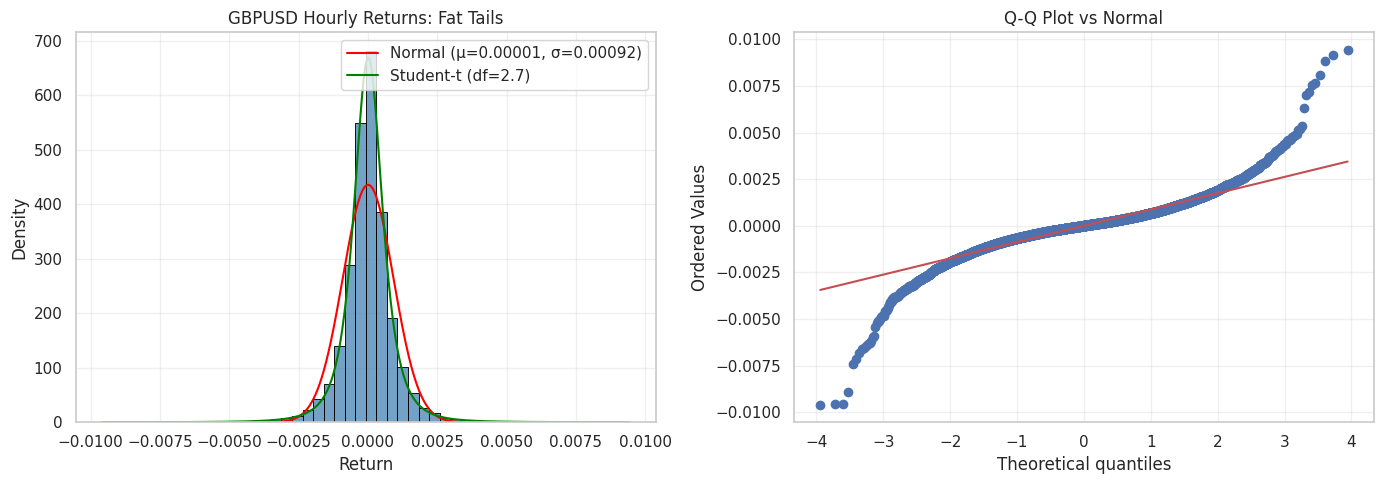

In [22]:
# Fit Normal and Student-t distributions
mu, sigma = returns.mean(), returns.std(ddof=1)
t_params = stats.t.fit(returns.values)  # df, loc, scale
df_t, loc_t, scale_t = t_params

# Compute stats
kurt = stats.kurtosis(returns, fisher=True)
jb_stat, jb_p = stats.jarque_bera(returns)
three_sigma_events = (np.abs(returns - mu) > 3 * sigma).sum()

# Plot histogram with overlays
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
sns.histplot(returns, bins=50, stat='density', edgecolor='black', color='steelblue', ax=ax)
x = np.linspace(returns.min(), returns.max(), 500)
ax.plot(x, stats.norm.pdf(x, mu, sigma), label=f'Normal (μ={mu:.5f}, σ={sigma:.5f})', color='red')
ax.plot(x, stats.t.pdf(x, df_t, loc_t, scale_t), label=f'Student-t (df={df_t:.1f})', color='green')
ax.set_title('GBPUSD Hourly Returns: Fat Tails')
ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Q-Q plot
ax = axes[1]
stats.probplot(returns, dist=stats.norm, plot=ax)
ax.set_title('Q-Q Plot vs Normal')
ax.grid(True, alpha=0.3)

fat_tails_path = fig_dir / '01_fat_tails.png'
plt.tight_layout()
plt.savefig(fat_tails_path, dpi=150)
print(f'Saved: {fat_tails_path}')

print('--- Fat Tails Diagnostics ---')
print(f'Kurtosis (Fisher): {kurt:.3f}')
print(f'3-sigma events: {three_sigma_events}')
print(f'Jarque-Bera: stat={jb_stat:.3f}, p={jb_p:.3g}')

## 4. Stationarity Analysis
- ADF test on returns
- Rolling 1-week mean and volatility (168 hours)
- Visual highlight for regime changes
- Save figure as `02_stationarity.png`

ADF: stat=-131.733, p=0
Saved: /home/ghost/Quant _validation/results/figures/02_stationarity.png


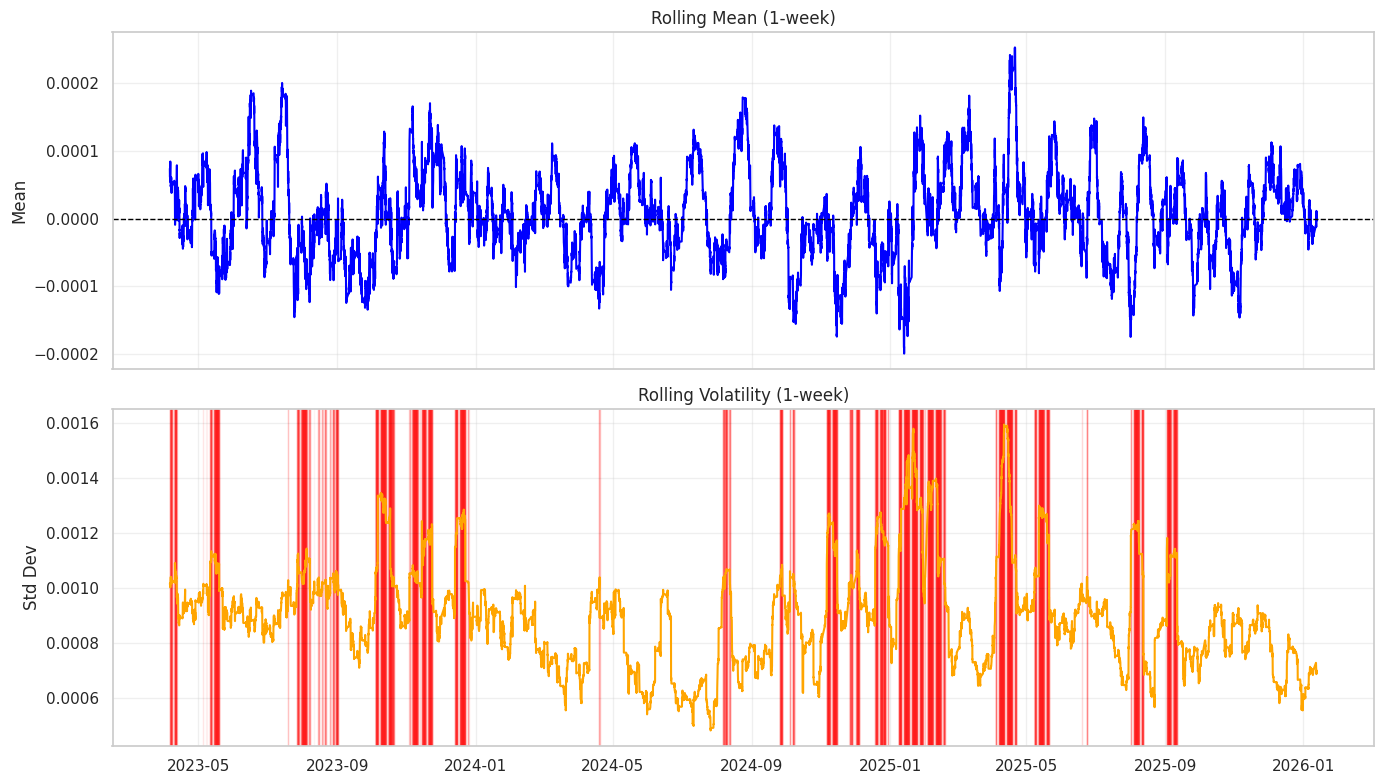

In [23]:
# ADF test
adf_stat, adf_p, _, _, _, _ = adfuller(returns, autolag='AIC')

# Rolling stats
window = 168  # 1 week of hourly bars
roll_mean = returns.rolling(window).mean()
roll_std = returns.rolling(window).std()

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax[0].plot(returns.index, roll_mean, label='Rolling Mean (168h)', color='blue')
ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
ax[0].set_title('Rolling Mean (1-week)')
ax[0].set_ylabel('Mean')
ax[0].grid(True, alpha=0.3)

ax[1].plot(returns.index, roll_std, label='Rolling Vol (168h)', color='orange')
ax[1].set_title('Rolling Volatility (1-week)')
ax[1].set_ylabel('Std Dev')
ax[1].grid(True, alpha=0.3)

# Highlight high volatility regimes (top 20% of rolling std)
threshold = roll_std.quantile(0.8)
high_vol = roll_std > threshold
# Use .items() instead of deprecated .iteritems()
for t, is_high in high_vol.items():
    if is_high:
        ax[1].axvspan(t, t + pd.Timedelta(hours=1), color='red', alpha=0.05)

stationarity_path = fig_dir / '02_stationarity.png'
plt.tight_layout()
plt.savefig(stationarity_path, dpi=150)
print(f'ADF: stat={adf_stat:.3f}, p={adf_p:.3g}')
print(f'Saved: {stationarity_path}')

## 5. Regime Analysis
- 20-hour rolling volatility
- Classify regimes: Low / Normal / High (tertiles)
- Mean, std, skew, kurtosis per regime
- Save distributions as `03_regimes.png` and CSV summary

/tmp/ipykernel_38290/1927347092.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['tail_3sigma'] = reg_df.groupby('regime').apply(lambda g: (np.abs(g['ret'] - g['ret'].mean()) > 3*g['ret'].std(ddof=1)).sum())


Saved regime summary: /home/ghost/Quant _validation/results/csv/gbpusd_regime_summary.csv
Saved: /home/ghost/Quant _validation/results/figures/03_regimes.png
            mean       std      skew      kurt  count  tail_3sigma
regime                                                            
High    0.000009  0.001207 -0.197773  8.583984   5865          101
Low     0.000006  0.000603  0.015243  0.976844   5693           53
Normal  0.000002  0.000821 -0.064249  1.598197   5692           66
Saved: /home/ghost/Quant _validation/results/figures/03_regimes.png
            mean       std      skew      kurt  count  tail_3sigma
regime                                                            
High    0.000009  0.001207 -0.197773  8.583984   5865          101
Low     0.000006  0.000603  0.015243  0.976844   5693           53
Normal  0.000002  0.000821 -0.064249  1.598197   5692           66


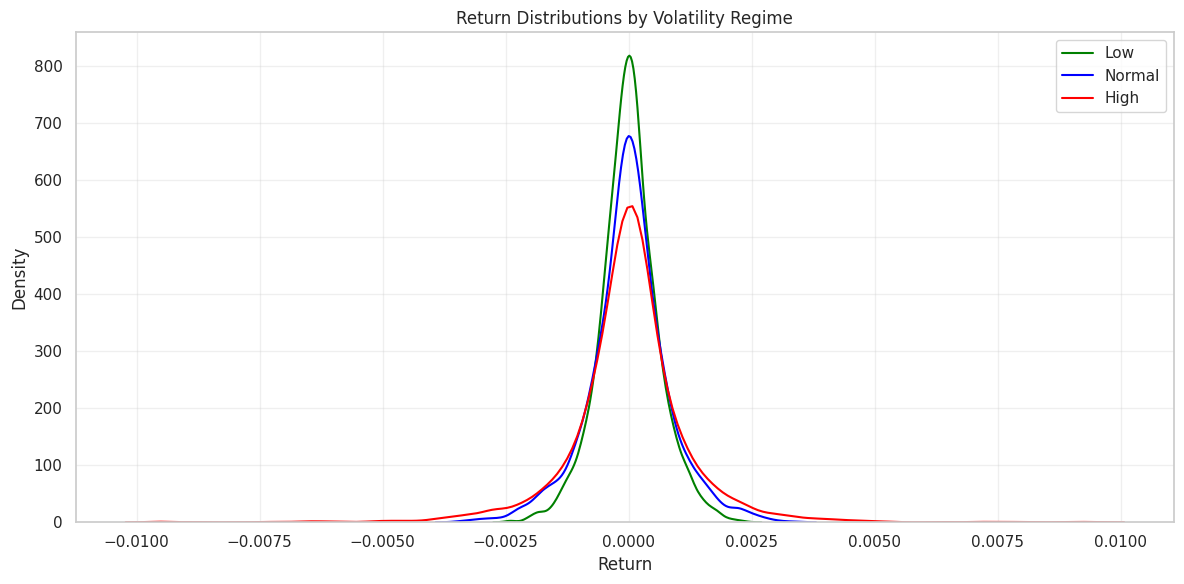

In [32]:
roll20 = returns.rolling(20).std()
q_low, q_high = roll20.quantile(0.33), roll20.quantile(0.66)
regime = pd.Series(index=roll20.index, dtype='object')
regime[roll20 <= q_low] = 'Low'
regime[(roll20 > q_low) & (roll20 <= q_high)] = 'Normal'
regime[roll20 > q_high] = 'High'
regime.name = 'Regime'

reg_df = pd.DataFrame({'ret': returns, 'vol20': roll20, 'regime': regime}).dropna()
summary = reg_df.groupby('regime').agg(
    mean=('ret','mean'),
    std=('ret','std'),
    skew=('ret', lambda x: stats.skew(x, bias=False)),
    kurt=('ret', lambda x: stats.kurtosis(x, fisher=True)),
    count=('ret','count'),
)
summary['tail_3sigma'] = reg_df.groupby('regime').apply(lambda g: (np.abs(g['ret'] - g['ret'].mean()) > 3*g['ret'].std(ddof=1)).sum())

# Save CSV summary
csv_path = csv_dir / 'gbpusd_regime_summary.csv'
summary.to_csv(csv_path)
print(f'Saved regime summary: {csv_path}')

# Plot distributions by regime
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for label, color in [('Low','green'),('Normal','blue'),('High','red')]:
    sns.kdeplot(reg_df[reg_df['regime']==label]['ret'], label=label, color=color, ax=ax)
ax.set_title('Return Distributions by Volatility Regime')
ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)
regimes_path = fig_dir / '03_regimes.png'
plt.tight_layout()
plt.savefig(regimes_path, dpi=150)
print(f'Saved: {regimes_path}')
print(summary)

## 6. Autocorrelation Analysis
- ACF of returns, squared returns, and absolute returns
- Ljung-Box test
- Save figure as `04_autocorrelation.png`

Saved: /home/ghost/Quant _validation/results/figures/04_autocorrelation.png
Ljung-Box (returns):
      lb_stat  lb_pvalue
12   9.759382   0.637061
24  39.168703   0.026216
48  63.876000   0.062242
Ljung-Box (squared):
       lb_stat      lb_pvalue
12  278.391377   1.595133e-52
24  416.229163   3.472320e-73
48  792.098041  2.289490e-135
Ljung-Box (absolute):
        lb_stat  lb_pvalue
12  1933.636800        0.0
24  3621.626800        0.0
48  6508.555628        0.0
Ljung-Box (returns):
      lb_stat  lb_pvalue
12   9.759382   0.637061
24  39.168703   0.026216
48  63.876000   0.062242
Ljung-Box (squared):
       lb_stat      lb_pvalue
12  278.391377   1.595133e-52
24  416.229163   3.472320e-73
48  792.098041  2.289490e-135
Ljung-Box (absolute):
        lb_stat  lb_pvalue
12  1933.636800        0.0
24  3621.626800        0.0
48  6508.555628        0.0


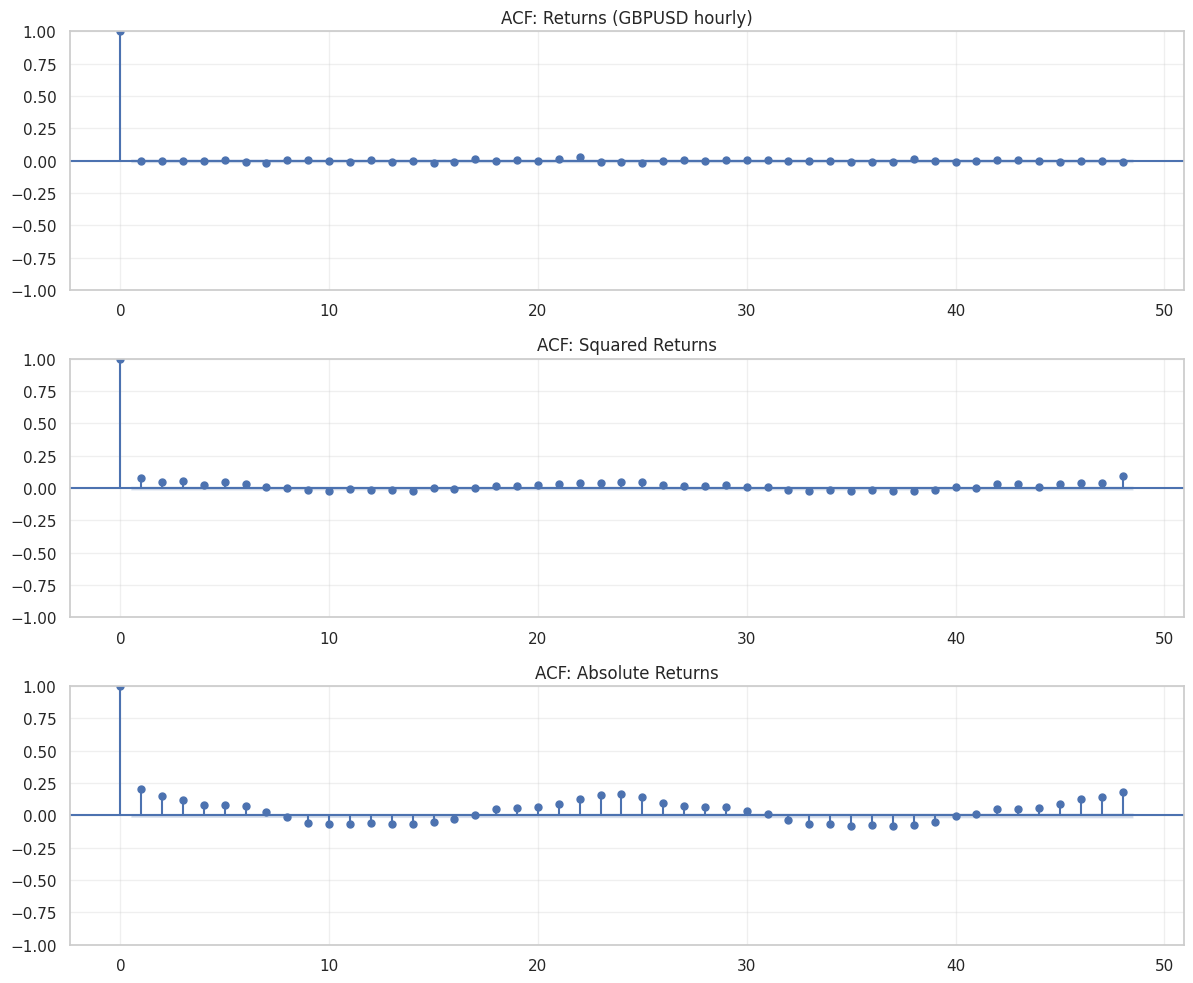

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
plot_acf(returns, ax=axes[0], lags=48)
axes[0].set_title('ACF: Returns (GBPUSD hourly)')
axes[0].grid(True, alpha=0.3)

plot_acf(returns**2, ax=axes[1], lags=48)
axes[1].set_title('ACF: Squared Returns')
axes[1].grid(True, alpha=0.3)

plot_acf(np.abs(returns), ax=axes[2], lags=48)
axes[2].set_title('ACF: Absolute Returns')
axes[2].grid(True, alpha=0.3)

auto_path = fig_dir / '04_autocorrelation.png'
plt.tight_layout()
plt.savefig(auto_path, dpi=150)
print(f'Saved: {auto_path}')

# Ljung-Box tests
lb_ret = acorr_ljungbox(returns, lags=[12,24,48], return_df=True)
lb_sq = acorr_ljungbox(returns**2, lags=[12,24,48], return_df=True)
lb_abs = acorr_ljungbox(np.abs(returns), lags=[12,24,48], return_df=True)
print('Ljung-Box (returns):')
print(lb_ret)
print('Ljung-Box (squared):')
print(lb_sq)
print('Ljung-Box (absolute):')
print(lb_abs)

## 7. Hypothesis-Specific Test
- Events: hourly moves > 0.5%
- Forward returns: 1h, 4h, 24h
- t-test vs 0, mean, std, win rate
- Save histogram as `05_hypothesis_test.png`

Events count (>|0.20%|): 711
Forward returns summary after thresholded moves:
1h: {'mean': -1.5097719032000986e-05, 'std': 0.0013717303794061491, 'win_rate': 0.49295774647887325, 'count': 710} t= -0.293 p= 0.7694
4h: {'mean': 4.9231558376775464e-05, 'std': 0.0023949717728568255, 'win_rate': 0.5211267605633803, 'count': 710} t= 0.548 p= 0.584
24h: {'mean': 0.00029170551631251484, 'std': 0.0047739492479871295, 'win_rate': 0.5225352112676056, 'count': 710} t= 1.628 p= 0.1039
Saved: /home/ghost/Quant _validation/results/figures/05_hypothesis_test.png
Saved: /home/ghost/Quant _validation/results/figures/05_hypothesis_test.png


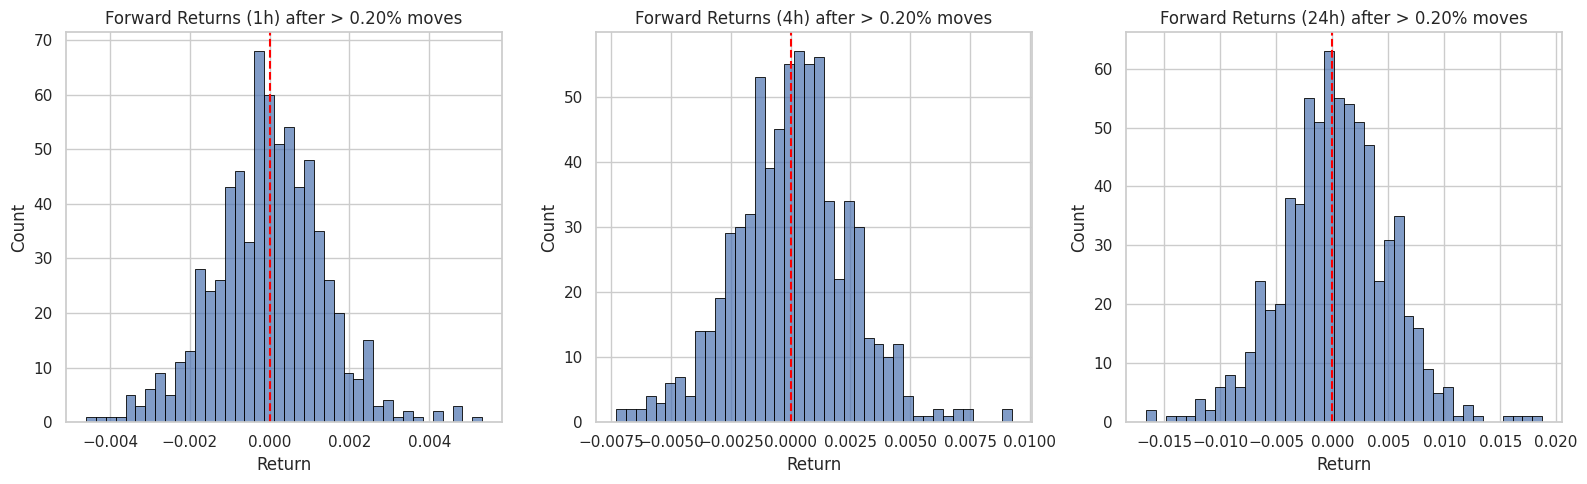

In [33]:
# Identify events using configurable threshold
events = returns[np.abs(returns) > event_threshold]
print(f"Events count (>|{event_threshold*100:.2f}%|): {len(events)}")

# Forward returns from prices
prices = df['close']
fwd_1h = prices.shift(-1) / prices - 1
fwd_4h = prices.shift(-4) / prices - 1
fwd_24h = prices.shift(-24) / prices - 1

fwd_df = pd.DataFrame({
    'ret': returns,
    'fwd_1h': fwd_1h,
    'fwd_4h': fwd_4h,
    'fwd_24h': fwd_24h
}).loc[events.index].dropna()

# t-tests
def ttest(x):
    t, p = stats.ttest_1samp(x, 0.0)
    return t, p

t1, p1 = ttest(fwd_df['fwd_1h'])
t4, p4 = ttest(fwd_df['fwd_4h'])
t24, p24 = ttest(fwd_df['fwd_24h'])

# Stats
def stats_summary(x):
    return {
        'mean': float(x.mean()),
        'std': float(x.std(ddof=1)),
        'win_rate': float((x > 0).mean()),
        'count': int(len(x))
    }

s1 = stats_summary(fwd_df['fwd_1h'])
s4 = stats_summary(fwd_df['fwd_4h'])
s24 = stats_summary(fwd_df['fwd_24h'])

print('Forward returns summary after thresholded moves:')
print('1h:', s1, 't=', round(t1,3), 'p=', round(p1,4))
print('4h:', s4, 't=', round(t4,3), 'p=', round(p4,4))
print('24h:', s24, 't=', round(t24,3), 'p=', round(p24,4))

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for ax, col, title in zip(axes, ['fwd_1h','fwd_4h','fwd_24h'], ['1h','4h','24h']):
    sns.histplot(fwd_df[col], bins=40, edgecolor='black', alpha=0.7, ax=ax)
    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(f"Forward Returns ({title}) after > {event_threshold*100:.2f}% moves")
    ax.set_xlabel('Return')
    ax.set_ylabel('Count')
hypo_path = fig_dir / '05_hypothesis_test.png'
plt.tight_layout()
plt.savefig(hypo_path, dpi=150)
print(f'Saved: {hypo_path}')


In [ ]:
# Persist hypothesis summary to CSV
from pathlib import Path
import pandas as pd

csv_dir = Path("results/csv")
csv_dir.mkdir(parents=True, exist_ok=True)

summary_rows = []
for horizon, res in [("1h", res_1h), ("4h", res_4h), ("24h", res_24h)]:
    summary_rows.append({
        "threshold": event_threshold,
        "horizon": horizon,
        "events": int(res.get("n", 0)),
        "mean": float(res.get("mu", float("nan"))),
        "std": float(res.get("sigma", float("nan"))),
        "t_stat": float(res.get("t", float("nan"))),
        "p_value": float(res.get("p", float("nan"))),
        "win_rate": float(res.get("win_rate", float("nan")))
    })

hypo_summary_df = pd.DataFrame(summary_rows)
hypo_summary_path = csv_dir / "gbpusd_hypothesis_summary.csv"
hypo_summary_df.to_csv(hypo_summary_path, index=False)
print(f"Hypothesis summary saved: {hypo_summary_path}")

In [ ]:
# Threshold/Horizon sweep for hypothesis robustness
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

csv_dir = Path("results/csv")
csv_dir.mkdir(parents=True, exist_ok=True)

thresholds = [0.001, 0.002, 0.003]  # 0.1%, 0.2%, 0.3%
horizons = [1, 4, 24]

sweep_rows = []
for th in thresholds:
    ev = returns.abs() > th
    for h in horizons:
        fwd = prices.pct_change(h).shift(-h)
        ev_fwd = fwd[ev]
        ev_fwd = ev_fwd.dropna()
        n = int(ev_fwd.shape[0])
        if n >= 5:
            t_stat, p_val = stats.ttest_1samp(ev_fwd.values, 0.0, nan_policy='omit')
        else:
            t_stat, p_val = np.nan, np.nan
        mu = float(ev_fwd.mean()) if n > 0 else np.nan
        sd = float(ev_fwd.std(ddof=1)) if n > 1 else np.nan
        win_rate = float((ev_fwd > 0).mean()) if n > 0 else np.nan
        sweep_rows.append({
            "threshold": th,
            "horizon": h,
            "events": n,
            "mean": mu,
            "std": sd,
            "t_stat": float(t_stat) if pd.notna(t_stat) else np.nan,
            "p_value": float(p_val) if pd.notna(p_val) else np.nan,
            "win_rate": win_rate
        })

sweep_df = pd.DataFrame(sweep_rows)
sweep_path = csv_dir / "gbpusd_hypothesis_grid.csv"
sweep_df.to_csv(sweep_path, index=False)
print(f"Hypothesis sweep saved: {sweep_path}\n", sweep_df)

## 8. Regime-Dependent Hypothesis Test
- Repeat hypothesis test per volatility regime
- Output mean, t-stat, p-value, and sample size per regime

In [27]:
# Merge regime with events DataFrame
events_df = pd.DataFrame({'ret': returns}).loc[events.index]
events_df = events_df.join(reg_df[['regime']])
events_fwd = events_df.join(fwd_df[['fwd_1h','fwd_4h','fwd_24h']])
events_fwd = events_fwd.dropna()

def regime_ttest(df, col):
    out = {}
    for r in ['Low','Normal','High']:
        x = df[df['regime']==r][col]
        if len(x) < 5:
            out[r] = {'mean': np.nan, 't': np.nan, 'p': np.nan, 'n': len(x)}
            continue
        t, p = stats.ttest_1samp(x, 0.0)
        out[r] = {'mean': float(x.mean()), 't': float(t), 'p': float(p), 'n': int(len(x))}
    return out

res_1h = regime_ttest(events_fwd, 'fwd_1h')
res_4h = regime_ttest(events_fwd, 'fwd_4h')
res_24h = regime_ttest(events_fwd, 'fwd_24h')

print('Regime-dependent hypothesis results:')
print('1h:', res_1h)
print('4h:', res_4h)
print('24h:', res_24h)

# Save CSV summaries
def save_regime_results(res, name):
    rows = []
    for r, d in res.items():
        rows.append({'regime': r, 'mean': d['mean'], 't': d['t'], 'p': d['p'], 'n': d['n']})
    pd.DataFrame(rows).to_csv(csv_dir / f'gbpusd_{name}_regime_results.csv', index=False)

save_regime_results(res_1h, 'fwd1h')
save_regime_results(res_4h, 'fwd4h')
save_regime_results(res_24h, 'fwd24h')
print('Saved regime-dependent CSV results')

Regime-dependent hypothesis results:
1h: {'Low': {'mean': -6.177407852514527e-05, 't': -0.30024131077091404, 'p': 0.767091619014028, 'n': 21}, 'Normal': {'mean': -9.120337074999471e-06, 't': -0.09359508059856295, 'p': 0.9255289240147195, 'n': 192}, 'High': {'mean': -1.5434648179663482e-05, 't': -0.2463031451550209, 'p': 0.8055494718011573, 'n': 497}}
4h: {'Low': {'mean': 0.0003927133257490199, 't': 0.7941400899687149, 'p': 0.4364359538597412, 'n': 21}, 'Normal': {'mean': 5.386322391405749e-05, 't': 0.3269534580440718, 'p': 0.7440611152128673, 'n': 192}, 'High': {'mean': 3.2928948924108894e-05, 't': 0.3001934234580089, 'p': 0.7641553938716154, 'n': 497}}
24h: {'Low': {'mean': 0.0009077196636515041, 't': 0.9552710751446976, 'p': 0.350845476961757, 'n': 21}, 'Normal': {'mean': 0.00019862589623184193, 't': 0.6946196210267297, 'p': 0.4881377948414981, 'n': 192}, 'High': {'mean': 0.0003016350735788537, 't': 1.325218007562196, 'p': 0.18570897476569848, 'n': 497}}
Saved regime-dependent CSV re

## 9. Textual Summary
- Fat tails confirmed?
- Stationarity?
- Hypothesis significance?
- Sample size sufficient?
- Regime dependency?

In [28]:
# Summarize diagnostics
summary_text = []

summary_text.append(f"Fat tails: Kurtosis={kurt:.3f}, JB p-value={jb_p:.3g}")
summary_text.append(f"Stationarity (ADF p-value): {adf_p:.3g}")
summary_text.append(f"Hypothesis (>0.5% moves) results: 1h p={p1:.3g}, 4h p={p4:.3g}, 24h p={p24:.3g}")
summary_text.append(f"Sample sizes: 1h={s1['count']}, 4h={s4['count']}, 24h={s24['count']}")

def regime_note(res):
    return ", ".join([f"{r}(n={d['n']}, p={d['p']:.3g})" for r,d in res.items() if not np.isnan(d['p'])])

summary_text.append('Regime dependency (p-values): ' + regime_note(res_1h))

print("\n".join(summary_text))

# Warnings
if s1['count'] < 30 or s4['count'] < 30 or s24['count'] < 30:
    print('⚠️ Low sample sizes for hypothesis tests - interpret cautiously.')
if jb_p < 0.05:
    print('⚠️ Fat tails / non-normality present - normal assumptions invalid.')
if (pd.Series([p1,p4,p24]) < 0.05).any():
    print('⚠️ Significant forward drift detected after large moves - check robustness.')

Fat tails: Kurtosis=10.136, JB p-value=0
Stationarity (ADF p-value): 0
Hypothesis (>0.5% moves) results: 1h p=0.769, 4h p=0.584, 24h p=0.104
Sample sizes: 1h=710, 4h=710, 24h=710
Regime dependency (p-values): Low(n=21, p=0.767), Normal(n=192, p=0.926), High(n=497, p=0.806)
⚠️ Fat tails / non-normality present - normal assumptions invalid.
